We're going to use the sequence generator by Geoffrey Aguirre's lab (https://cfn.upenn.edu/aguirre/wiki/public:web-based_sequence_evaluator) to generate the sequence of stimuli. The output should be identical to what one would get using their web interface, but allowing for a greater number of permutations.

In this example, we have 5 categories plus a blank trial, totaling 6 trials types.

In [1]:
# Import code to evaluate efficiency of the sequences
from evalseqshard import EvaluateSeqshard, vec2sim

# import other code
import numpy as np
from scipy.spatial.distance import squareform

# Intermixed trials

In [263]:
# define parameters
par = {
    'N': 6,  # number of trial types
    'perms': 10000,  # how many permutations to compute
    'TrialDuration': 1.5,  # duration of the trials in seconds
    'BlankLength': 1,  # leave this as it is (or see evalseqshard.py)
    'doubleblanks': False,  # leave this as it is (or see evalseqshard.py)
    'target': 0,  # leave this as it is (or see evalseqshard.py)
    'numSeqs': 10000  # number of sequences to output
}

We are going to make a fake similarity matrix because each of our stimuli correspond to a different category

In [10]:
mat = np.zeros((5, 5))
np.fill_diagonal(mat, 1.)

In [11]:
# let's visualize the similarity matrices
%matplotlib inline
from matplotlib import pyplot as plt

And these are the similarity matrices

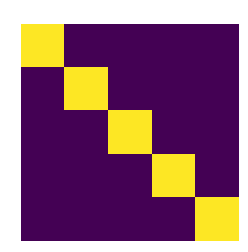

In [12]:
fig, ax = plt.subplots(1, 1)
ax.matshow(mat)
ax.set_axis_off()

In [20]:
# Now compute the sequences (it can take a while given the number of permutations)
# set seed to get same sequence across runs
np.random.seed(485)
result = EvaluateSeqshard(par, mat[..., None])

Because the similarity matrix is non informative, we cannot look at the efficiency. Whatever.

In [21]:
seq = result['BestSeqs']

In [22]:
seq.shape

(36, 10000)

So each stimulus is repeated 6 times. We have a total of 12 stimuli for category, so we need to repeat it twice, that is picking up two sequences that start with the same label type.

In [189]:
def augment_sequence(sequence, all_sequences, nrep):
    """
    Given a sequence, it returns a new sequence of length len(sequence)*nrep by
    appending compatible sequences from all_sequences
    
    Parameters
    ----------
    sequence : array (n_trials)
    all_sequences : array (n_trials, n_sequences)
    nrep : int
    
    Returns
    -------
    augmented_sequence : array (nrep * ntrials)
    """
    end_trial_type = sequence[-1]
    new_sequences = [sequence]
    iseq = 1
    for seq in all_sequences.T:
        if iseq >= nrep:
            break
        if np.array_equal(seq, sequence):
            continue
        if seq[0] == end_trial_type:
            new_sequences.append(seq)
            iseq += 1
    return np.hstack(new_sequences)

In [304]:
def plot_design(onsets, durations, stimuli, TR=1., sfreq=10):
    run_len = onsets[-1] + durations[-1]
    time = np.arange(0, run_len * sfreq)
    n_stimuli = len(np.unique(stimuli))
    pulses = np.zeros((n_stimuli, time.shape[0]))

    for trial_type, dur, onset in zip(stimuli, durations, onsets):
        istart = int(onset * sfreq)
        iend = int(istart + dur * sfreq)
        pulses[trial_type, istart:iend] = 1.
        
    fig, axs = plt.subplots(6, 1, figsize=(12, 6), sharex=True)
    for istim, (pulse, ax) in enumerate(zip(pulses, axs.flat)):
        ax.plot(np.linspace(0, run_len, len(time)), pulse)
        # add a bar at every tr
        for tr in np.arange(0, run_len, TR):
            ax.vlines(tr, ymin=0, ymax=1, color='lightgray', alpha=0.5, zorder=0)
        ax.set_ylabel("Stim {0}".format(istim))
    ax.set_xlim(0, run_len)
    plt.tight_layout()
    return fig

In [300]:
this_seq = augment_sequence(seq[:, 0], seq, 4).astype(int)

In [301]:
stim_duration = 1.5

In [302]:
durations = stim_duration * np.ones(this_seq.shape)
onsets = np.arange(this_seq.shape[0]) * stim_duration

run_len = onsets[-1] + stim_duration

So this is how it looks like whenever we don't have any jitter

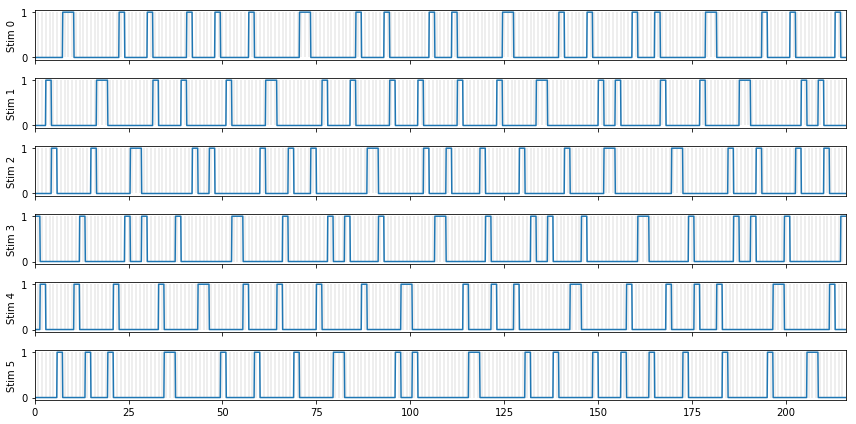

In [305]:
plot_design(onsets, durations, this_seq);

And the problem here is that the onset of the stimulus will always be at the same point in the TR

In [295]:
TR = 1.0  # s
for stim_type in range(6):
    print("stim type {0}: {1}".format(stim_type, np.unique(np.modf(onsets[this_seq == stim_type]/TR)[0])))

stim type 0: [ 0.   0.5]
stim type 1: [ 0.   0.5]
stim type 2: [ 0.   0.5]
stim type 3: [ 0.   0.5]
stim type 4: [ 0.   0.5]
stim type 5: [ 0.   0.5]


We can solve this problem by adding some random jitter to the onset

In [296]:
# add some small but random jitter to the onset
rng = np.random.RandomState(42)
jitter = rng.choice(np.arange(0, 0.25, 0.05), len(this_seq))

onsets_random = onsets.copy()
for i, jitter_ in enumerate(jitter):
    onsets_random[i:] += jitter_
assert(np.all(np.round(np.diff(onsets_random), 2) >= stim_duration))

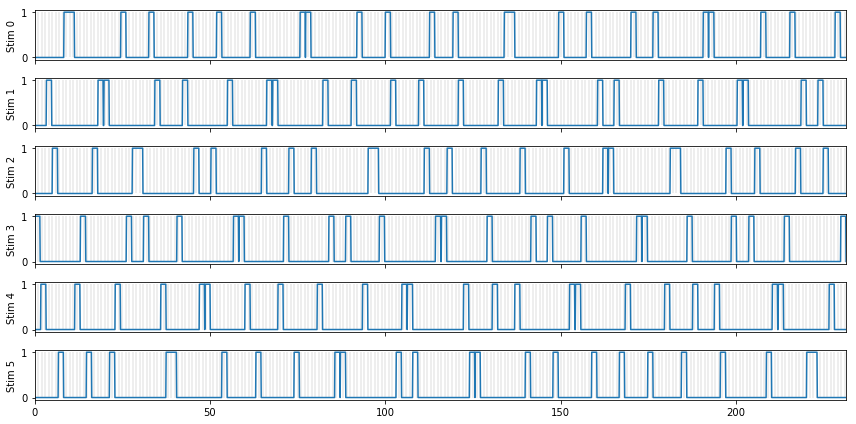

In [306]:
plot_design(onsets_random, durations, this_seq);

In this case we should have much more variance wrt the onset of the TR

In [307]:
TR = 1.0  # s
for stim_type in range(6):
    print("stim type {0}: {1}".format(stim_type, 
                                      np.unique(
                                          np.round(
                                              np.modf(onsets_random[this_seq == stim_type]/TR)[0], 2)
                                      )))

stim type 0: [ 0.    0.05  0.2   0.3   0.35  0.4   0.45  0.55  0.6   0.65  0.75  0.9
  0.95  1.  ]
stim type 1: [ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.45  0.5   0.55  0.75
  0.85  0.9   0.95]
stim type 2: [ 0.    0.1   0.15  0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65
  0.75  0.85  0.9   0.95]
stim type 3: [ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.55  0.6   0.65  0.7
  0.75  0.8   0.85  0.9 ]
stim type 4: [ 0.    0.05  0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65  0.75
  0.85  0.9 ]
stim type 5: [ 0.    0.05  0.1   0.2   0.4   0.45  0.5   0.55  0.6   0.65  0.7   0.85
  0.9 ]


In [308]:
def get_duration(seconds):
    return('{0:02.0f}:{1:02.2f}'.format(*divmod(seconds, 60)))

print("Without jitter: {0}".format(get_duration(run_len)))
print("With jitter: {0}".format(get_duration(run_len_jitter)))

Without jitter: 03:36.00
With jitter: 03:51.35


# Standard Kanwisher

So here each category is presented continuosly, without jitter, with some fixation in between. From the paper

> Each functional run contained three 18-s rest blocks, at the beginning,middle, and end of the run, during which a series of six uniform colorfields were presented for 3 s each (these colorfields were designed tomaintain the interest of children, for whom the dynamic localizer wasoriginally designed, while approximating afixation baseline conditionby avoiding any pattern visual input). Participants were instructed towatch the movies and static images but were not asked to performany overt task.

> Each run contained two sets offive consecutive stimulus blocks(faces, bodies, scenes, objects or scrambled objects) sandwichedbetween these rest blocks, to make two blocks per stimulus categoryper run. Each block lasted 18 s and contained stimuli from one of the five stimulus categories. The order of stimulus category blocks in eachrun was palindromic (e.g.,fixation, faces, objects, scenes, bodies,scrambled objects,fixation, scrambled objects, bodies, scenes, objects,faces,fixation) and was randomized across runs. 

Let's build one of these runs. In our case we have 12 clips per category, lasting each 1.5 seconds, thus a total of 18s for each block.

In [309]:
duration = 1.5  # duration of each clip
n_stim_category = 12
n_categories = 5  # without counting the fixation
n_fixations = 3
len_fixation = int(duration * n_stim_category)
n_repetitions_block = 2

len_run_s = len_fixation * n_fixations + duration * n_stim_category * n_categories * n_repetitions_block
print("Run duration: {0}".format(get_duration(len_run_s)))

Run duration: 03:54.00


In [313]:
# now let's build it
block1_order = np.arange(1, 6)
rng.shuffle(block1_order)
block2_order = np.arange(1, 6)
rng.shuffle(block2_order)

onsets = []
durations = []
stimuli = []

t = 0
phase = ['fixation', block1_order, 'fixation', block2_order, 'fixation']
for ph in phase:
    if isinstance(ph, str):
        stimuli.append(0)
        onsets.append(t)
        durations.append(len_fixation)
        t += len_fixation
    else:
        for stim_type in ph:
            onsets.extend(np.arange(n_stim_category)*duration + t)
            durations.extend(np.ones(n_stim_category)*duration)
            stimuli.extend(np.ones(n_stim_category, dtype=int)*stim_type)
            t += n_stim_category*duration

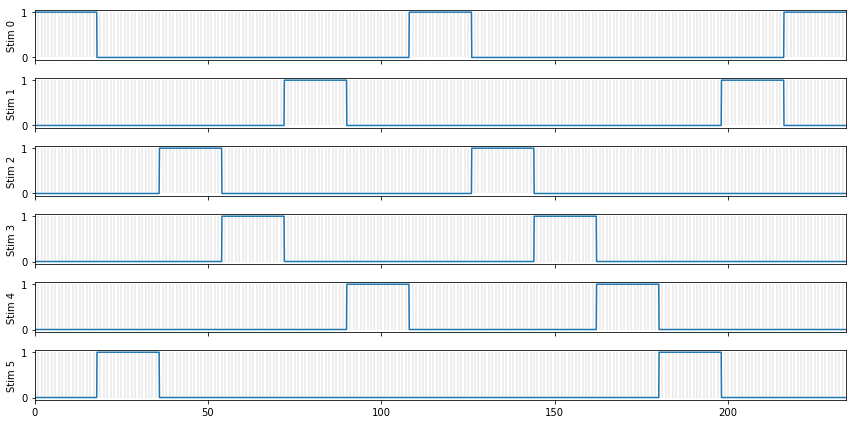

In [314]:
plot_design(onsets, durations, stimuli);

# Standard Block Design

So here we have one repetition of each category in each run, counterbalanced across runs. It's a standard on/off block design.

In [321]:
# now let's build it
n_stim_category = 12
block_order = np.arange(1, 6)
rng.shuffle(block_order)

onsets = []
durations = []
stimuli = []

t = 0
# build template
phase = []
for stim_type in block_order:
    phase.append('fixation')
    phase.append([stim_type] * n_stim_category)
phase.append('fixation')

for ph in phase:
    if isinstance(ph, str):
        stimuli.append(0)
        onsets.append(t)
        durations.append(len_fixation)
        t += len_fixation
    else:
        len_ph = len(ph)
        onsets.extend(np.arange(len_ph)*duration + t)
        durations.extend(np.ones(len_ph)*duration)
        stimuli.extend(np.ones(len_ph, dtype=int)*ph[0])
        t += len_ph*duration

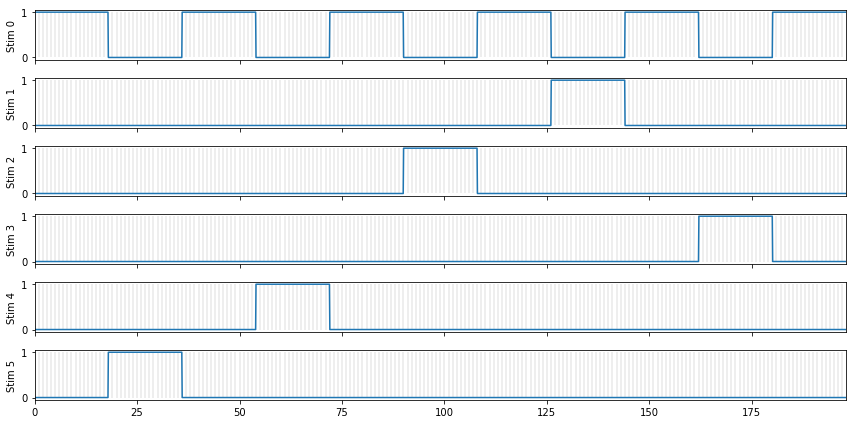

In [322]:
plot_design(onsets, durations, stimuli);

In [323]:
print("Duration: {0}".format(get_duration(onsets[-1] + durations[-1])))

Duration: 03:18.00
